In [392]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
import pandas as pd
import math 
import csv
import time
import dateutil
from datetime import datetime

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [94]:
#aid_re = r'(A[0-5])|(C[0-5])[-,+]?'
aid_re = r'((A[0-5])|(C[0-5]))[-,+]?'
boulder_re = r'V\d\d?[-,+]?'
ice_re = r'WI[1-6][+,-]?'
mixed_re = r'M\d\d?[+,-]?'
rock_re = r'5.\d\d?(([a-d]/[a-d])|([a-d]))?[+,-]?'

diff_regexes = {"aid_grade": aid_re, "boulder_grade": boulder_re, 
               "ice_grade": ice_re, "mixed_grade": mixed_re, 
               "rock_grade": rock_re}

user_type_regexes = {"Trad": rock_re, "Sport": rock_re, 
                     "Boulders": boulder_re, "Aid": aid_re, 
                     "Ice": ice_re, "Mixed": mixed_re}

typesdict = {"trad": 0, "alpine": 0, "ice": 0, "sport": 0,
        "boulder": 0, "aid": 0, "mixed": 0, "TR,": 0}


### Climbing Grade Conversions

For different types of climbing there are different types of grading systems. The ratings are ordinal systems, however there is a general agreement/acknowledgement within the climbing community that differences between grades are not always the same, especially between lower grades and grades higher up, or between a grade with a +,- appended, etc. 

Hence, we set off to write mapping functions below such that a computer can interpret the grades numerically and we can take averages of grades with some level of veracity. It should be noted, a similar mapping must already exist inside the mountainproject database, since the consensus ratings that they provide are averages of user ratings, not medians, as discussed here:

http://www.mountainproject.com/v/lies-damned-lies-and-statistics/110725878__3

Unforunately, we do not know what their conversion algorithms are, so we create our own below:


In [95]:
# rock letter to value conversion
def letter_to_num(letter):
    if letter == 'a':
        return 0.
    if letter == 'b':
        return .5
    if letter == 'c':
        return 1.
    if letter == 'd':
        return 1.5

# double digit +,- conversion
def dd_sign_to_num(sign):
    if sign == '-':
        return -.2
    elif sign == '+':
        return .2

# single digit +,- conversion
def sd_sign_to_num(sign):
    if sign == '-':
        return -.3
    elif sign == '+':
        return .3

# rock grade conversions
def rock_grade_convert(string):
    if isinstance(string, str):
        if string == '0':
            return np.nan
        number = 0
        searchobj = re.search(r'5.(\d)(\d)?([a-d])?([+,-])?', string)
    
        # if double digit grade
        if searchobj.group(2):
            number = 10 + int(searchobj.group(2)) * 2

            # check for letter 
            if searchobj.group(3):
                number += letter_to_num(searchobj.group(3))

            if searchobj.group(4):
                number += dd_sign_to_num(searchobj.group(4))

        # if single digit grade
        elif searchobj.group(1):
            number = int(searchobj.group(1))

            if searchobj.group(4):
                number += sd_sign_to_num(searchobj.group(4))

        return number
    else:
        return np.nan

# aid grade conversion
def aid_grade_convert(string):
    if isinstance(string, str):
        if string == '0':
            return np.nan
        number = 0
        searchobj = re.search(r'((A([0-5]))|(C([0-5])))([-,+]?)', string)
        if searchobj.group(3):
            number += int(searchobj.group(3))
        if searchobj.group(5):
            number += int(searchobj.group(5))
        if searchobj.group(6):
            number += sd_sign_to_num(searchobj.group(6))
        return number
    elif string == 0:
        return np.nan
        
        
def boulder_grade_convert(string):
    if isinstance(string, str):
        if string == '0':
            return np.nan
        number = 0
        searchobj = re.search(r'V(\d\d?)([-,+]?)', string)
        if searchobj.group(1):
            number += int(searchobj.group(1))
        if searchobj.group(2):
            number += sd_sign_to_num(searchobj.group(2))
        return number
    elif string == 0:
        return np.nan

    
def ice_grade_convert(string):
    if isinstance(string, str):
        if string == '0':
            return np.nan
        number = 0
        searchobj = re.search(r'WI([1-6])([+,-]?)', string)
        if searchobj.group(1):
            number += int(searchobj.group(1))
        if searchobj.group(2):
            number += sd_sign_to_num(searchobj.group(2))
        return number
    elif string == 0:
        return np.nan    

def mixed_grade_convert(string):
    if isinstance(string, str):
        if string == '0':
            return np.nan
        number = 0
        searchobj = re.search(r'M(\d\d?)([+,-]?)', string)
        if searchobj.group(1):
            number += int(searchobj.group(1))
        if searchobj.group(2):
            number += sd_sign_to_num(searchobj.group(2))
        return number
    elif string == 0:
        return np.nan    


# UsersDF Cleaning and Initial EDA

In [96]:
usersdf = pd.DataFrame.from_csv('../fin_proj_dfs/raw_data/users.csv')

### 'usersdf' First Look

In [97]:
print "Number of Users:", len(usersdf)
usersdf.head()

Number of Users: 11323


,location_state,user_id,climbs_trad,gender,age,climbs_aid,climbs_ice,climbs_boulder,user_link,climbs_mixed,location_place,climbs_sport,member_date,user_name,lead_diff_sport,boulder_diff,follow_diff_sport,lead_diff_ice,lead_diff_trad,follow_diff_ice,follow_diff_trad,follow_diff_mixed,lead_diff_mixed,follow_diff_aid,lead_diff_aid
10101,WA,10101,0,Male,37,0,0,0,https://www.mountainproject.com/u/michael-koma...,0,Seattle,0,"(2001, 1, 1, 0, 0, 0, 0, 1, -1)",michael-komarnitsky,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10102,undef,10102,1,Male,0,1,1,0,https://www.mountainproject.com/u/ben-mottinge...,1,undef,1,"(2001, 1, 1, 0, 0, 0, 0, 1, -1)",ben-mottinger,5.10d,NaN,5.11c,WI4,5.10a,WI6,5.11a,M8,M5,C1,C3
10106,NM,10106,1,Male,35,1,0,1,https://www.mountainproject.com/u/patrick-vern...,0,Albuquerque,1,"(2001, 1, 1, 0, 0, 0, 0, 1, -1)",patrick-vernon,5.13a,V8,5.13a,NaN,5.12d,NaN,5.12d,NaN,NaN,C2,C2
10107,undef,10107,0,undef,0,0,0,0,https://www.mountainproject.com/u/matt-bauman/...,0,undef,0,"(2001, 1, 1, 0, 0, 0, 0, 1, -1)",matt-bauman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10108,CO,10108,0,Male,36,0,0,0,https://www.mountainproject.com/u/quinn-steven...,0,Denver,0,"(2001, 1, 1, 0, 0, 0, 0, 1, -1)",quinn-stevens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
usersdf.describe(include=['number'])

,user_id,climbs_trad,age,climbs_aid,climbs_ice,climbs_boulder,climbs_mixed,climbs_sport
count,1.132300e+04,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000
mean,1.019186e+08,0.481939,15.086726,0.081162,0.129383,0.366864,0.055816,0.542436
std,2.403621e+07,0.499696,17.085963,0.273096,0.335638,0.481970,0.229575,0.498218
min,1.010100e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.063474e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.072737e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.082118e+08,1.000000,30.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.113856e+08,1.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [99]:
usersdf.describe(include=['object'])

,location_state,gender,user_link,location_place,member_date,user_name,lead_diff_sport,boulder_diff,follow_diff_sport,lead_diff_ice,lead_diff_trad,follow_diff_ice,follow_diff_trad,follow_diff_mixed,lead_diff_mixed,follow_diff_aid,lead_diff_aid
count,11321,11323,11323,11323,11323,11323,6142,4154,6142,1465,5457,1465,5457,632,632,919,919
unique,831,3,11323,2042,3762,11291,31,15,31,7,29,7,31,11,11,6,6
top,undef,Male,https://www.mountainproject.com/u/anthony-kiet...,undef,"(2001, 1, 1, 0, 0, 0, 0, 1, -1)",daveb,5.11a,V4,5.11a,WI3,5.9,WI5,5.11a,M6,M1,C3,C2
freq,5276,6222,1,4280,61,3,698,820,752,385,975,522,752,100,163,213,345


#### Notes:
- some data needs to be converted to numeric values, namely the gender representation and the climb difficulty descriptions
- there are obvious mistakes in age data, no way anyone 99 years old is climbing 
- it seems unreasonable to me that 61 people joined the website in 2001, might be some sort of default, but maybe that's just when the website was created, who knows
- lots of defaults need to be changed
- need to get rid of zero 0 entries in clims difficulties

### Data Cleaning

#### convert gender to binary and replace default placeholders with np.nan

In [100]:
# fix age such that where there was no age, it is set to NaN and not 0
usersdf.age.replace(0,np.nan, inplace=1)

In [101]:
print "Total User Profiles Scraped: ", len(usersdf)
print "Undeclared Gender: ", len(usersdf[usersdf.gender == 'undef'])
print "Declared Men: ", len(usersdf[usersdf.gender == 'Male'])
print "Declared Women: ", len(usersdf[usersdf.gender == 'Female'])

Total User Profiles Scraped:  11323
Undeclared Gender:  4309
Declared Men:  6222
Declared Women:  792


^^^^ YIKES!

points to note:
- women might be reporting gender at a lower rate, 
- it is generally well known that the climbing community is predominantly male, though the usual anecdotal estimate is about a 30-70 ratio...

In [102]:
# convert male,female to binary, numeric and add numpy.nan
usersdf.gender.replace(['Male','Female','undef'],[0,1,np.nan], inplace=1)

In [103]:
# check/replace if any 'None' or 'undef' strings
usersdf.replace(['None','undef'], [np.nan,np.nan], inplace=1)

#### figure out weird age data

In [104]:
usersdf.sort_values('age', ascending=0)[:10]

,location_state,user_id,climbs_trad,gender,age,climbs_aid,climbs_ice,climbs_boulder,user_link,climbs_mixed,location_place,climbs_sport,member_date,user_name,lead_diff_sport,boulder_diff,follow_diff_sport,lead_diff_ice,lead_diff_trad,follow_diff_ice,follow_diff_trad,follow_diff_mixed,lead_diff_mixed,follow_diff_aid,lead_diff_aid
105854232,ca,105854232,1,0,99,1,1,1,https://www.mountainproject.com/u/livinonthele...,1,davis,1,"(2006, 8, 29, 0, 0, 0, 1, 241, -1)",livinontheledge,0,V0,0,WI1,0,WI1,0,M1,M1,C0,C0
14258,NaN,14258,1,0,86,0,0,0,https://www.mountainproject.com/u/byron-murray...,0,NaN,1,"(2005, 7, 24, 0, 0, 0, 6, 205, -1)",byron-murray,5.12a,NaN,5.12a,NaN,5.11a,NaN,5.11d,NaN,NaN,NaN,NaN
10641,Colorado,10641,1,0,85,0,0,0,https://www.mountainproject.com/u/robcalm//10641,0,Loveland,1,"(2002, 5, 2, 0, 0, 0, 3, 122, -1)",robcalm,5.7,NaN,5.8,NaN,5.7,NaN,5.8,NaN,NaN,NaN,NaN
107329391,NaN,107329391,0,1,85,0,0,0,https://www.mountainproject.com/u/caitlin-mac/...,0,Tempe,0,"(2011, 10, 16, 0, 0, 0, 6, 289, -1)",caitlin-mac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107276276,CA,107276276,0,1,81,0,0,1,https://www.mountainproject.com/u/tram//107276276,0,San Diego,1,"(2011, 9, 6, 0, 0, 0, 1, 249, -1)",tram,5.10c,V3,5.10c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107183979,NaN,107183979,0,1,81,0,0,0,https://www.mountainproject.com/u/climbnplay//...,0,NaN,0,"(2011, 6, 21, 0, 0, 0, 1, 172, -1)",climbnplay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106781575,WY 82633,106781575,1,0,76,0,0,0,https://www.mountainproject.com/u/rodger-rauba...,0,Douglas,1,"(2010, 5, 31, 0, 0, 0, 0, 151, -1)",rodger-raubach,5.7,NaN,5.10c,NaN,5.7,NaN,5.10b,NaN,NaN,NaN,NaN
107071855,NaN,107071855,1,0,75,0,0,1,https://www.mountainproject.com/u/josh-prancku...,0,Denver,1,"(2011, 3, 19, 0, 0, 0, 5, 78, -1)",josh-pranckun,5.0,V5,5.12a,NaN,5.0,NaN,5.11c,NaN,NaN,NaN,NaN
105843757,co,105843757,1,0,72,1,1,1,https://www.mountainproject.com/u/doug-cornick...,1,centennial,1,"(2006, 7, 22, 0, 0, 0, 5, 203, -1)",doug-cornick,5.11c,V4,5.11c,WI3,5.11a,WI3,5.11a,M2,M2,C2,C2
105818040,ca,105818040,1,0,71,0,0,0,https://www.mountainproject.com/u/john-robinso...,0,Elk Grove,1,"(2006, 4, 23, 0, 0, 0, 6, 113, -1)",john-robinson,5.10c,NaN,5.11a,NaN,5.10b,NaN,5.10c,NaN,NaN,NaN,NaN


Upon user profile examination, first two are clearly false, third is pretty clearly true, will leave the rest as is...

In [105]:
usersdf.replace([99,86],np.nan,inplace=1)

#### difficulty grade conversions

In [106]:
usersdf.columns

Index([u'location_state', u'user_id', u'climbs_trad', u'gender', u'age', u'climbs_aid', u'climbs_ice', u'climbs_boulder', u'user_link', u'climbs_mixed', u'location_place', u'climbs_sport', u'member_date', u'user_name', u'lead_diff_sport', u'boulder_diff', u'follow_diff_sport', u'lead_diff_ice', u'lead_diff_trad', u'follow_diff_ice', u'follow_diff_trad', u'follow_diff_mixed', u'lead_diff_mixed', u'follow_diff_aid', u'lead_diff_aid'], dtype='object')

In [107]:
# add numeric version of climbing grades
user_grade_to_number_dict = {u'lead_diff_sport': rock_grade_convert, u'boulder_diff': boulder_grade_convert, 
                        u'follow_diff_sport': rock_grade_convert, u'lead_diff_ice': ice_grade_convert, 
                        u'lead_diff_trad': rock_grade_convert, u'follow_diff_ice': ice_grade_convert, 
                        u'follow_diff_trad': rock_grade_convert, u'follow_diff_mixed': mixed_grade_convert, 
                        u'lead_diff_mixed': mixed_grade_convert, u'follow_diff_aid': aid_grade_convert, 
                        u'lead_diff_aid': aid_grade_convert}

for column, converter in user_grade_to_number_dict.items():
    usersdf[column + "_number"] = usersdf[column].apply(converter)

There is a discrepancy between counts of follow_diff_trad and its numeric equivalent, likewise for sport climbs. We explore below why these differences in count arise!

In [108]:
# find where the conversions failed and why
differences = {}
for column in user_grade_to_number_dict:
        differences[column]=usersdf[np.array([item == item for item in usersdf[column].values]) & np.array([item != item for item in usersdf[column + "_number"].values])]     
        
differences["follow_diff_trad"][["follow_diff_trad", "follow_diff_trad_number"]].head()
print "Count Difference Trad: ", len(differences["follow_diff_trad"])
print "Non-nan converted to nan Trad: ", differences["follow_diff_trad"]["follow_diff_trad"].unique()

print "Count Difference Sport: ", len(differences["follow_diff_sport"])
print "Non-nan converted to nan Sport: ", differences["follow_diff_sport"]["follow_diff_sport"].unique()

Count Difference Trad:  241
Non-nan converted to nan Trad:  ['0']
Count Difference Sport:  245
Non-nan converted to nan Sport:  ['0']


It seems our conversion function was not the issue! Woohoo! We replace instances of zero strings in our ratings columns below:

In [148]:
for column in user_grade_to_number_dict:
    usersdf[column].replace("0",np.nan,inplace=1)

#### User Location

In [110]:
usersdf.head()

,location_state,user_id,climbs_trad,gender,age,climbs_aid,climbs_ice,climbs_boulder,user_link,climbs_mixed,location_place,climbs_sport,member_date,user_name,lead_diff_sport,boulder_diff,follow_diff_sport,lead_diff_ice,lead_diff_trad,follow_diff_ice,follow_diff_trad,follow_diff_mixed,lead_diff_mixed,follow_diff_aid,lead_diff_aid,lead_diff_sport_number,follow_diff_aid_number,lead_diff_ice_number,follow_diff_sport_number,follow_diff_mixed_number,lead_diff_aid_number,lead_diff_mixed_number,lead_diff_trad_number,boulder_diff_number,follow_diff_ice_number,follow_diff_trad_number
10101,WA,10101,0,0,37,0,0,0,https://www.mountainproject.com/u/michael-koma...,0,Seattle,0,"(2001, 1, 1, 0, 0, 0, 0, 1, -1)",michael-komarnitsky,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10102,NaN,10102,1,0,NaN,1,1,0,https://www.mountainproject.com/u/ben-mottinge...,1,NaN,1,"(2001, 1, 1, 0, 0, 0, 0, 1, -1)",ben-mottinger,5.10d,NaN,5.11c,WI4,5.10a,WI6,5.11a,M8,M5,C1,C3,11.5,1,4,13,8,3,5,10.0,NaN,6,12.0
10106,NM,10106,1,0,35,1,0,1,https://www.mountainproject.com/u/patrick-vern...,0,Albuquerque,1,"(2001, 1, 1, 0, 0, 0, 0, 1, -1)",patrick-vernon,5.13a,V8,5.13a,NaN,5.12d,NaN,5.12d,NaN,NaN,C2,C2,16.0,2,NaN,16,NaN,2,NaN,15.5,8,NaN,15.5
10107,NaN,10107,0,NaN,NaN,0,0,0,https://www.mountainproject.com/u/matt-bauman/...,0,NaN,0,"(2001, 1, 1, 0, 0, 0, 0, 1, -1)",matt-bauman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10108,CO,10108,0,0,36,0,0,0,https://www.mountainproject.com/u/quinn-steven...,0,Denver,0,"(2001, 1, 1, 0, 0, 0, 0, 1, -1)",quinn-stevens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### replace abbreviations

In [111]:
usersdf.location_state.unique()

array([' WA', nan, ' NM', ' CO', ' WI', ' AZ', ' CO 80220', ' Kolorado',
       ' CO 80033', ' Male', ' Colorado', ' UT', ' AB', ' CO 80027',
       ' Espa\xc3\xb1a', ' NE 68502', ' NY', ' CO 80401', ' Wyoming',
       ' co', ' CA', 'CO', ' CA 90230', ' CO 80210', ' MT', ' ID',
       ' UT 84108', ' NV', ' UT 84403', ' WY', ' NC', ' CO 80122',
       ' CO 80455', ' CA 92109', ' IL', ' New York', ' AR', ' MN',
       ' CO 80301', '  WA', ' SD', ' Ca', ' Arizona', ' ca', 'ID', ' TX',
       'AZ', ' SD 57783', ' Alberta', ' OR', ' CO 80907', ' CA 90638',
       ' NH', ' Co', ' Missouri', ' CT', ' CA 95991', ' CO 80302',
       ' UT 84103', ' FL', ' nv', 'colorado', 'Ca', ' or', 'Utah',
       ' NC 27701', 'NM', '  MN', ' NY 12084', ' CO 80304', '  CO',
       ' CA 92037', ' Oregon', ' GA', ' Nevada', ' ID 83702', ' UT 84118',
       'wa', ' Utah', ' ME', ' CA 94110', ' KS 66027', ' Co.',
       ' Appalachia', ' TN', ' CO 80218', 'IN', ' VT', ' AZ 85705', 'co',
       ' Ut', ' Az', ' Idaho

In [112]:
# import lists of full state names and corresponding abbreviations
states_full = []
states_ab = []
with open('../fin_proj_dfs/raw_data/states.csv') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
        states_full.append(row[0])
        states_ab.append(row[1])

In [113]:
usersdf.location_state.replace(states_full, states_ab, inplace=1, regex=True)

##### extract states and zip codes, clean places, drop old columns

In [114]:
# extract states
usersdf.insert(6,"user_state",usersdf.location_state.str.lstrip().str.extract(r'^([A-Z]{2})', 
                                                                              flags=re.I))

In [115]:
# get list of state abbreviations in caps and lowercase
states_caseless = []
for e in states_ab:
    states_caseless.append(e)
    states_caseless.append(e.lower())

# remove random double caps that aren't states
states_to_remove = list(np.setdiff1d(usersdf.user_state.unique(), states_caseless))
states_to_remove.remove(np.nan)
usersdf.user_state.replace(states_to_remove,np.nan,inplace=1)

In [116]:
usersdf.user_state.unique()

array(['WA', nan, 'NM', 'CO', 'WI', 'AZ', 'UT', 'NE', 'NY', 'WY', 'co',
       'CA', 'MT', 'ID', 'NV', 'NC', 'IL', 'AR', 'MN', 'SD', 'ca', 'TX',
       'OR', 'NH', 'MO', 'CT', 'FL', 'nv', 'or', 'GA', 'wa', 'ME', 'KS',
       'TN', 'IN', 'VT', 'ut', 'KY', 'ny', 'NJ', 'AK', 'WV', 'MD', 'VA',
       'PA', 'MA', 'nh', 'SC', 'fl', 'OK', 'OH', 'IA', 'DC', 'AL', 'LA',
       'mt', 'al', 'az', 'ND', 'mn', 'ne', 'mi', 'RI', 'va', 'tn', 'wi',
       'md', 'pa', 'wy', 'MI', 'ma', 'nc', 'oh', 'MS', 'wv', 'nm', 'DE',
       'HI', 'sc', 'hi', 'id', 'mo', 'nj', 'tx', 'ky'], dtype=object)

In [117]:
# clean location places
usersdf.insert(7,"user_city",usersdf.location_place.str.lstrip().str.rstrip())

In [118]:
# extract zip codes
usersdf.insert(8,"user_zip_code",usersdf.location_state.str.extract(r'(\d{5})'))

In [119]:
# add country, this isn't accurate but creates less mistakes then not having it when geocoding!
usersdf.insert(6, "user_country", "USA")

In [120]:
# drop old columns
usersdf.drop(["location_state","location_place"],axis=1,inplace=1)

##### add geocoded data! woot!

In order to get more precise user location data as well as latitude longitude values for users, we used harvard's license to ArcMap, a subset of the ArcGIS package, to geocode the rough location data above. We exported the above dataset, geocoded, and now load and combine the two!

In [121]:
usersgeo = pd.DataFrame.from_csv('../fin_proj_dfs/raw_data/user-loc-geocoded_fin.csv')

In [122]:
usersgeo.head()

,YCoord,ADDR_TYPE,TYPE,CITY,REGION,POSTAL,COUNTRY,USER_ID
XCoord,,,,,,,,
-111.913112,40.660010,SubAdmin,NaN,Salt Lake,Utah,NaN,USA,10365
-89.948681,43.426752,SubAdmin,NaN,Sauk,Wisconsin,NaN,USA,105816622
-111.913112,40.660010,SubAdmin,NaN,Salt Lake,Utah,NaN,USA,105826680
-111.913112,40.660010,SubAdmin,NaN,Salt Lake,Utah,NaN,USA,105829353
-111.913112,40.660010,SubAdmin,NaN,Salt Lake,Utah,NaN,USA,105834752


In [123]:
usersgeo.reset_index(inplace=1)
#usersgeo.drop(["Column3"], axis=1, inplace=1)
usersgeo.head()

,XCoord,YCoord,ADDR_TYPE,TYPE,CITY,REGION,POSTAL,COUNTRY,USER_ID
0,-111.913112,40.660010,SubAdmin,NaN,Salt Lake,Utah,NaN,USA,10365
1,-89.948681,43.426752,SubAdmin,NaN,Sauk,Wisconsin,NaN,USA,105816622
2,-111.913112,40.660010,SubAdmin,NaN,Salt Lake,Utah,NaN,USA,105826680
3,-111.913112,40.660010,SubAdmin,NaN,Salt Lake,Utah,NaN,USA,105829353
4,-111.913112,40.660010,SubAdmin,NaN,Salt Lake,Utah,NaN,USA,105834752


In [124]:
usersgeo.columns

Index([u'XCoord', u'YCoord', u'ADDR_TYPE', u'TYPE', u'CITY', u'REGION', u'POSTAL', u'COUNTRY', u'USER_ID'], dtype='object')

In [125]:
usersgeo.columns = [u'longitude', u'latitude', u'ADDR_TYPE', u'TYPE', u'user_city_geo',
 u'user_state_geo', u'user_zip_geo', u'user_country_geo', u'user_id']

x - longitude
y latititude

In [126]:
usersdf = usersdf.merge(usersgeo[[u'longitude', u'latitude', u'user_city_geo',
 u'user_state_geo', u'user_zip_geo', u'user_country_geo', u'user_id']], 
                        how='left', left_on='user_id',right_on='user_id')

#### Dates Conversion

In [127]:
usersdf.member_date

0            (2001, 1, 1, 0, 0, 0, 0, 1, -1)
1            (2001, 1, 1, 0, 0, 0, 0, 1, -1)
2            (2001, 1, 1, 0, 0, 0, 0, 1, -1)
3            (2001, 1, 1, 0, 0, 0, 0, 1, -1)
4            (2001, 1, 1, 0, 0, 0, 0, 1, -1)
5            (2001, 1, 1, 0, 0, 0, 0, 1, -1)
6            (2001, 1, 1, 0, 0, 0, 0, 1, -1)
7            (2001, 1, 1, 0, 0, 0, 0, 1, -1)
8            (2001, 1, 1, 0, 0, 0, 0, 1, -1)
9            (2001, 1, 1, 0, 0, 0, 0, 1, -1)
10           (2001, 1, 1, 0, 0, 0, 0, 1, -1)
11           (2001, 1, 1, 0, 0, 0, 0, 1, -1)
12           (2001, 1, 1, 0, 0, 0, 0, 1, -1)
13           (2001, 1, 1, 0, 0, 0, 0, 1, -1)
14           (2001, 1, 1, 0, 0, 0, 0, 1, -1)
15           (2001, 1, 1, 0, 0, 0, 0, 1, -1)
16           (2001, 1, 1, 0, 0, 0, 0, 1, -1)
17           (2001, 1, 1, 0, 0, 0, 0, 1, -1)
18           (2001, 1, 1, 0, 0, 0, 0, 1, -1)
19           (2001, 1, 1, 0, 0, 0, 0, 1, -1)
20           (2001, 1, 1, 0, 0, 0, 0, 1, -1)
21           (2001, 1, 1, 0, 0, 0, 0, 1, -1)
22        

In [128]:
usersdf['member_date'] = usersdf['member_date'].str.extract(r'\((\d\d\d\d, \d\d?, \d\d?)*') 


In [129]:
usersdf['member_date']  = pd.to_datetime(usersdf['member_date'], format='%Y, %m, %d', exact=False)

In [130]:
usersdf['member_date'].unique()

array(['2000-12-31T19:00:00.000000000-0500',
       '2001-05-24T20:00:00.000000000-0400',
       '2001-04-28T20:00:00.000000000-0400', ...,
       '2005-12-24T19:00:00.000000000-0500',
       '2005-12-29T19:00:00.000000000-0500',
       '2006-01-08T19:00:00.000000000-0500'], dtype='datetime64[ns]')

### Final 'usersdf' Overview

In [131]:
usersdf.head()

,user_id,climbs_trad,gender,age,climbs_aid,user_country,user_state,user_city,user_zip_code,climbs_ice,climbs_boulder,user_link,climbs_mixed,climbs_sport,member_date,user_name,lead_diff_sport,boulder_diff,follow_diff_sport,lead_diff_ice,lead_diff_trad,follow_diff_ice,follow_diff_trad,follow_diff_mixed,lead_diff_mixed,follow_diff_aid,lead_diff_aid,lead_diff_sport_number,follow_diff_aid_number,lead_diff_ice_number,follow_diff_sport_number,follow_diff_mixed_number,lead_diff_aid_number,lead_diff_mixed_number,lead_diff_trad_number,boulder_diff_number,follow_diff_ice_number,follow_diff_trad_number,longitude,latitude,user_city_geo,user_state_geo,user_zip_geo,user_country_geo
0,10101,0,0,37,0,USA,WA,Seattle,NaN,0,0,https://www.mountainproject.com/u/michael-koma...,0,0,2001-01-01,michael-komarnitsky,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.329447,47.603569,Seattle,Washington,NaN,USA
1,10102,1,0,NaN,1,USA,NaN,NaN,NaN,1,0,https://www.mountainproject.com/u/ben-mottinge...,1,1,2001-01-01,ben-mottinger,5.10d,NaN,5.11c,WI4,5.10a,WI6,5.11a,M8,M5,C1,C3,11.5,1,4,13,8,3,5,10.0,NaN,6,12.0,NaN,NaN,NaN,NaN,NaN,NaN
2,10106,1,0,35,1,USA,NM,Albuquerque,NaN,0,1,https://www.mountainproject.com/u/patrick-vern...,0,1,2001-01-01,patrick-vernon,5.13a,V8,5.13a,NaN,5.12d,NaN,5.12d,NaN,NaN,C2,C2,16.0,2,NaN,16,NaN,2,NaN,15.5,8,NaN,15.5,-106.649049,35.084233,Albuquerque,New Mexico,NaN,USA
3,10107,0,NaN,NaN,0,USA,NaN,NaN,NaN,0,0,https://www.mountainproject.com/u/matt-bauman/...,0,0,2001-01-01,matt-bauman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10108,0,0,36,0,USA,CO,Denver,NaN,0,0,https://www.mountainproject.com/u/quinn-steven...,0,0,2001-01-01,quinn-stevens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-104.992298,39.740012,Denver,Colorado,NaN,USA


In [132]:
usersdf.describe(include=['number'])

,user_id,climbs_trad,gender,age,climbs_aid,climbs_ice,climbs_boulder,climbs_mixed,climbs_sport,lead_diff_sport_number,follow_diff_aid_number,lead_diff_ice_number,follow_diff_sport_number,follow_diff_mixed_number,lead_diff_aid_number,lead_diff_mixed_number,lead_diff_trad_number,boulder_diff_number,follow_diff_ice_number,follow_diff_trad_number,longitude,latitude,user_zip_geo
count,1.132300e+04,11323.000000,7014.000000,5289.000000,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000,5992.000000,919.000000,1456.000000,5897.000000,632.000000,919.000000,632.000000,5249.000000,4154.000000,1428.000000,5216.000000,6849.000000,6849.000000,625.000000
mean,1.019186e+08,0.481939,0.112917,32.263566,0.081162,0.129383,0.366864,0.055816,0.542436,11.370577,2.536453,2.960852,12.384518,5.254747,1.764962,3.708861,9.217375,4.166346,4.320728,11.300613,-103.825262,39.199029,66411.654400
std,2.403621e+07,0.499696,0.316514,8.247961,0.273096,0.335638,0.481970,0.229575,0.498218,2.863089,1.553872,1.403180,2.884386,2.348411,1.183231,2.281473,2.805223,2.336287,1.378864,2.701004,15.790196,4.267475,31656.833459
min,1.010100e+04,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,-157.943631,20.890753,1040.000000
25%,1.063474e+08,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,2.000000,11.500000,4.000000,1.000000,1.000000,8.000000,3.000000,4.000000,10.000000,-115.139967,36.171911,40509.000000
50%,1.072737e+08,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11.500000,3.000000,3.000000,12.500000,5.000000,2.000000,4.000000,9.000000,4.000000,5.000000,11.500000,-105.325266,39.740012,80424.000000
75%,1.082118e+08,1.000000,0.000000,36.000000,0.000000,0.000000,1.000000,0.000000,1.000000,13.500000,4.000000,4.000000,14.000000,7.000000,2.000000,5.000000,11.000000,5.000000,5.000000,13.000000,-93.709056,40.847434,91107.000000
max,1.113856e+08,1.000000,1.000000,85.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.500000,5.000000,6.000000,19.500000,11.000000,5.000000,11.000000,19.500000,14.000000,6.000000,19.500000,-68.673988,64.845087,99504.000000


In [133]:
usersdf.describe(include=['object'])

,user_country,user_state,user_city,user_zip_code,user_link,user_name,lead_diff_sport,boulder_diff,follow_diff_sport,lead_diff_ice,lead_diff_trad,follow_diff_ice,follow_diff_trad,follow_diff_mixed,lead_diff_mixed,follow_diff_aid,lead_diff_aid,user_city_geo,user_state_geo,user_country_geo
count,11323,5467,7043,626,11323,11323,6142,4154,6142,1465,5457,1465,5457,632,632,919,919,6638,6845,6849
unique,1,84,2036,502,11323,11291,31,15,31,7,29,7,31,11,11,6,6,1433,52,1
top,USA,CO,Boulder,80301,https://www.mountainproject.com/u/anthony-kiet...,daveb,5.11a,V4,5.11a,WI3,5.9,WI5,5.11a,M6,M1,C3,C2,Boulder,Colorado,USA
freq,11323,1361,414,8,1,3,698,820,752,385,975,522,752,100,163,213,345,444,1711,6849


In [166]:
self_reported_climb_diffs = [u'lead_diff_sport_number', u'follow_diff_sport_number', u'lead_diff_trad_number',
        u'follow_diff_trad_number', u'lead_diff_ice_number',u'follow_diff_ice_number', u'lead_diff_mixed_number',
         u'follow_diff_mixed_number', u'lead_diff_aid_number', u'follow_diff_aid_number', u'boulder_diff_number']

In [167]:
user_basic_info = ['gender','age','member_date']            
sport = [u'lead_diff_sport_number',
         u'follow_diff_sport_number']
trad = [u'lead_diff_trad_number',
        u'follow_diff_trad_number']
ice = [u'lead_diff_ice_number',
       u'follow_diff_ice_number']
mixed = [u'lead_diff_mixed_number',
         u'follow_diff_mixed_number']
aid = [u'lead_diff_aid_number',
       u'follow_diff_aid_number']
boulder = [u'boulder_diff_number']

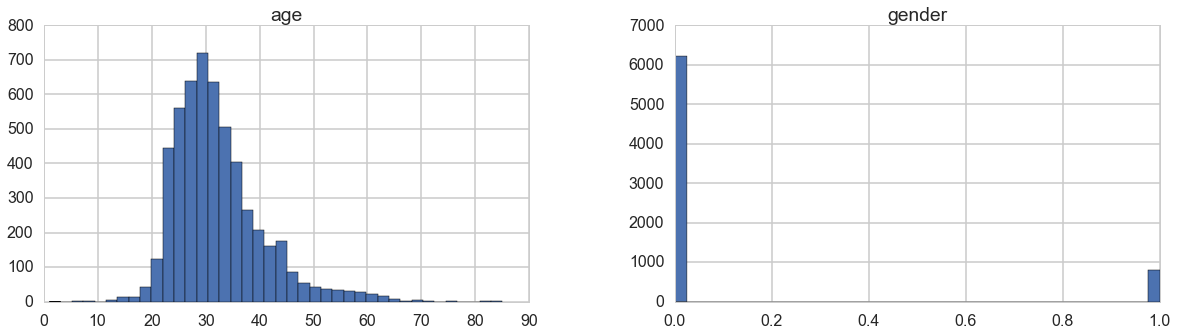

In [149]:
pd.DataFrame.hist(usersdf[user_basic_info], figsize=[20,50], bins=40, layout=(8,2));

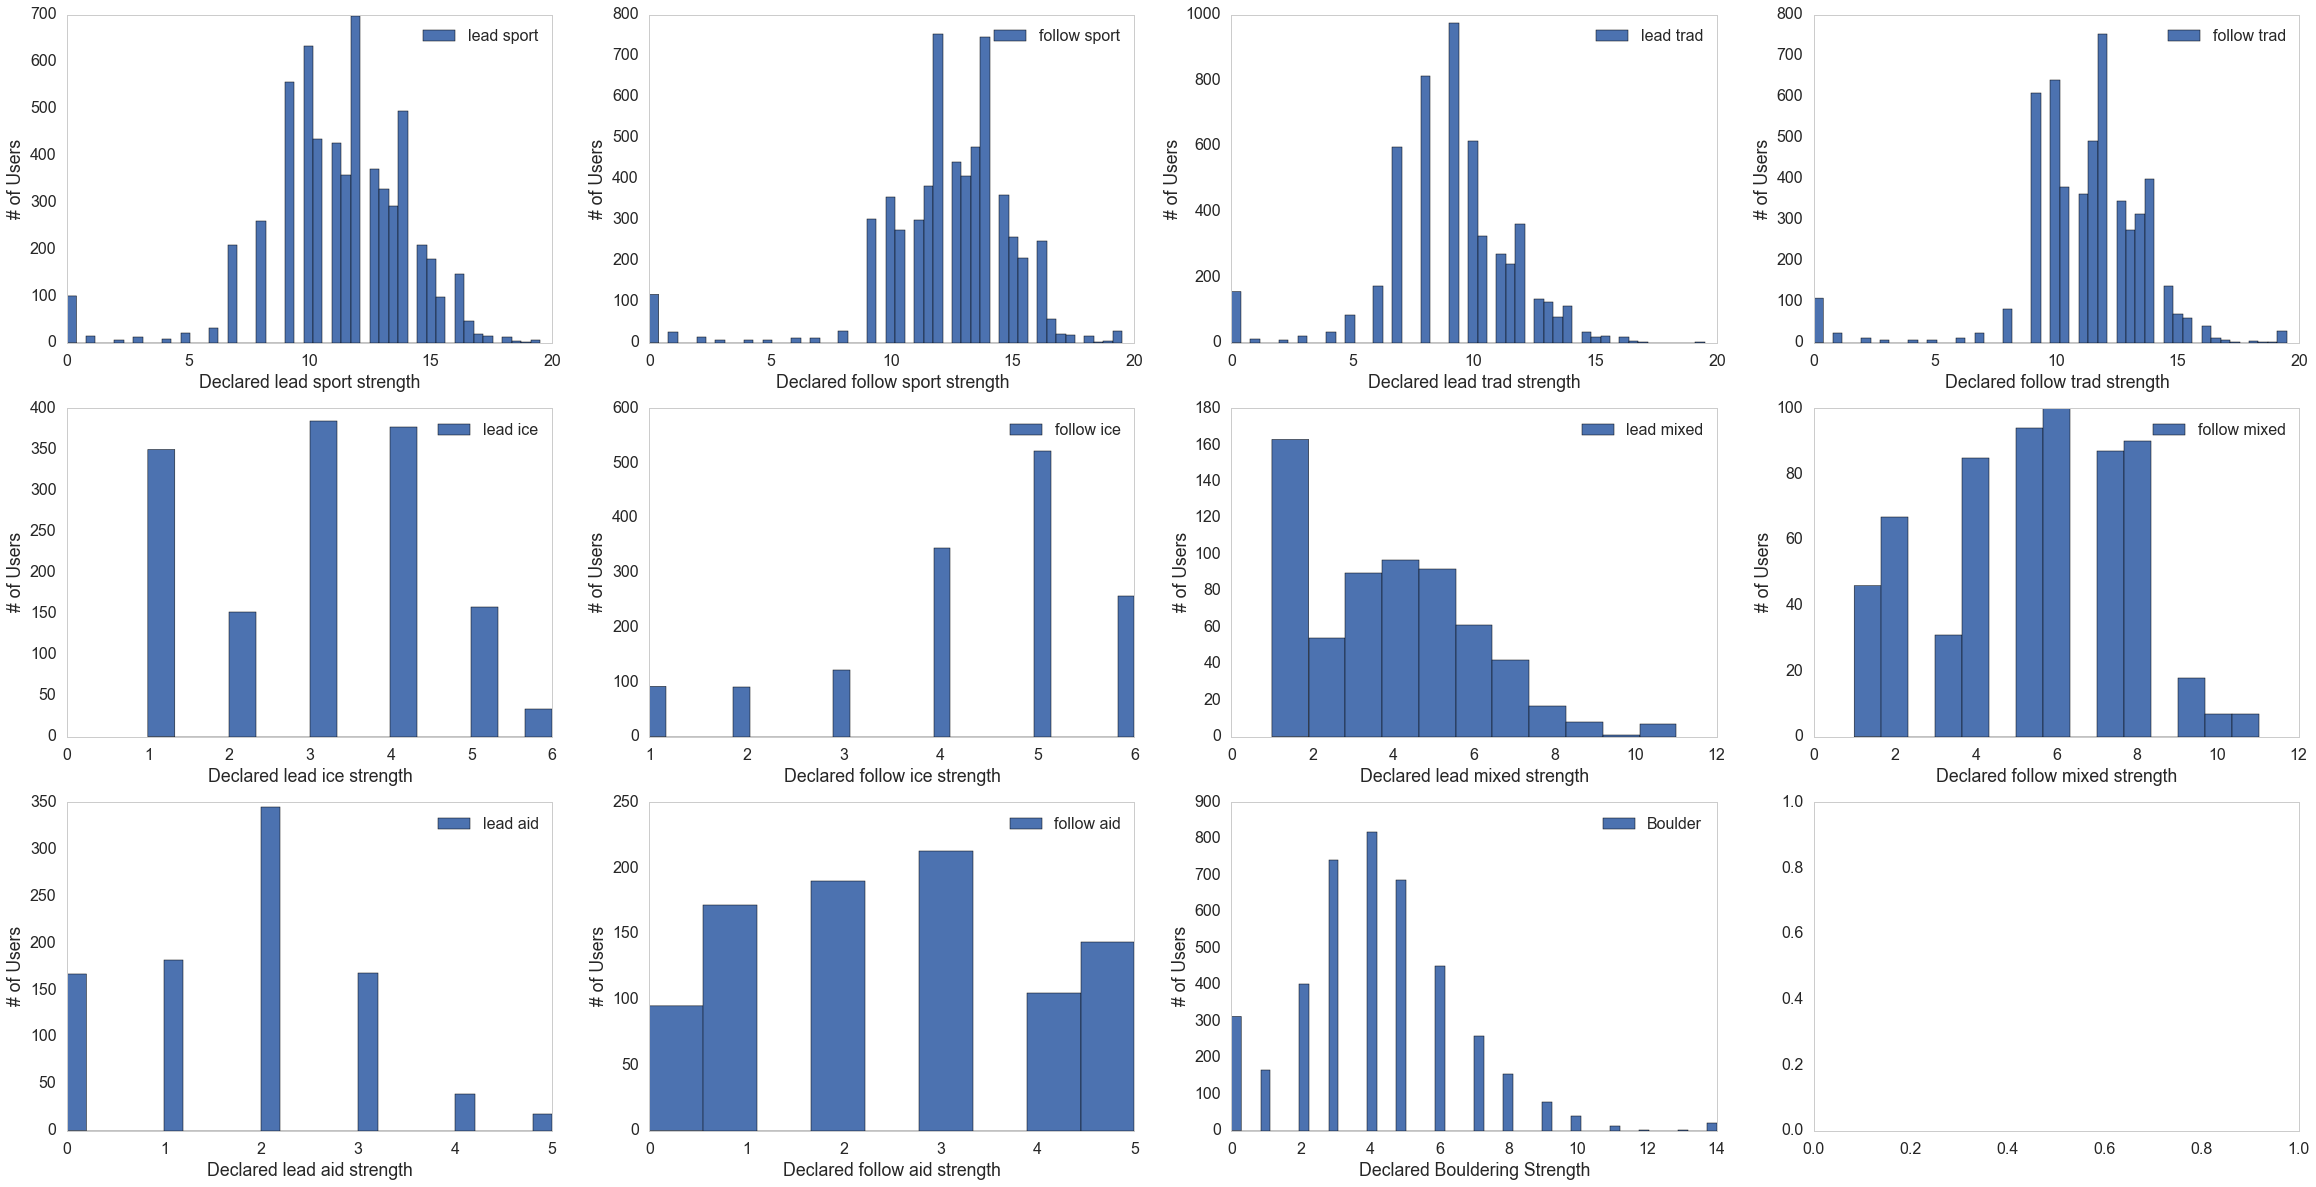

In [272]:
fig1, axes = plt.subplots(nrows=3, ncols=4, figsize=(40, 20))

# make a plot for each
for ax, ccol in zip(axes.ravel(), self_reported_climb_diffs):
    
    # get correct labels
    type_climb = ccol.split('_')[2]
    lead_follow = ccol.split('_')[0]
    if lead_follow == 'boulder':
        x_label = 'Declared Bouldering Strength' 
        label_ = 'Boulder'
    else:
        x_label = 'Declared ' + lead_follow + ' ' + type_climb + ' strength'
        label_ = lead_follow + ' ' + type_climb
        
    sns.distplot(usersdf[ccol][~np.isnan(usersdf[ccol])], hist_kws={"alpha": 1}, kde=False, ax=ax, label=label_)
    
    ax.set_ylabel('# of Users')
    ax.set_xlabel(x_label)
    ax.legend()
    sns.set_style({'axes.grid':False});


### Export Dataframe

In [203]:
usersdf.to_csv('../fin_proj_dfs/cleaned_data/cleaned-users.csv')

# ClimbDF Cleaning and Initial EDA

In [204]:
climbsdf = pd.DataFrame.from_csv('../fin_proj_dfs/raw_data/climbs.csv')

C:\Users\nolefp\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3006: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### 'climbsdf' First Look

In [205]:
climbsdf.describe(include=['number'])

,climb_id,fa_year,feet,page_views,pitches,avg_stars,state,latitude,longitude,"type_TR,",type_aid,type_alpine,type_boulder,type_ice,type_mixed,type_sport,type_trad
count,1.877300e+04,5908.000000,15137.000000,18773.000000,13206.000000,18773.000000,18773.000000,18773.000000,18773,18773.000000,18773.000000,18773.000000,18773.000000,18773.000000,18773.000000,18773.000000,18773.000000
mean,1.062857e+08,1987.141503,121.572967,2532.874394,1.515220,2.476971,38.760473,-104.646066,0,0.072178,0.004102,0.018377,0.137272,0.016140,0.002983,0.488308,0.383849
std,7.182032e+05,14.934810,1017.015325,4662.915426,1.676495,0.862664,3.802676,15.148212,0,0.258790,0.063914,0.134316,0.344143,0.126018,0.054537,0.499877,0.486335
min,1.057147e+08,1911.000000,4.000000,77.000000,1.000000,0.000000,21.309100,-158.228700,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.057956e+08,1977.000000,45.000000,796.000000,1.000000,2.076900,36.011800,-115.446270,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.059913e+08,1989.000000,65.000000,1369.000000,1.000000,2.545500,38.788600,-107.715400,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.065176e+08,1999.000000,90.000000,2545.000000,1.000000,3.066700,40.613440,-103.907650,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.110013e+08,2015.000000,90110.000000,139600.000000,35.000000,3.991300,64.820900,110.704550,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [206]:
climbsdf.describe(include=['object'])

,climb_name,climb_link,grade,area_0,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8,area_9,guide_aid_grade,guide_boulder_grade,guide_ice_grade,guide_mixed_grade,guide_rock_grade,concensus_aid_grade,concensus_boulder_grade,concensus_ice_grade,concensus_mixed_grade,concensus_rock_grade
count,18773,18773,855,18773,18773,18773,18438,15483,6989,2371,621,87,9,18773,18773,18773,18773,18773,18773,18773,18773,18773,18773
unique,16920,18773,2,1,41,323,1294,2558,1457,646,199,31,4,14,32,15,20,42,12,35,14,19,42
top,unknown,http://www.mountainproject.com/v/tigger-plus/1...,I,/destinations/,/v/colorado/105708956,/v/wasatch-range/105739213,/v/boulder-canyon/105744222,/v/mount-lemmon-catalina-highway/106822703,/v/1---lower-highway/106822869,/v/central-pinnacles/105931166,/v/motherlode-rock/105837583,/v/motherlode-rock---west-face/105852307,/v/south-astro-dome---northeast-face/106637669,0,0,0,0,0,0,0,0,0,0
freq,24,1,788,18773,3912,1077,543,430,132,74,17,7,5,18696,16260,18475,18717,2810,18696,16269,18475,18718,2811


In [207]:
climbsdf.dtypes

climb_id                     int64
climb_name                  object
climb_link                  object
fa_year                    float64
feet                       float64
page_views                   int64
pitches                    float64
avg_stars                  float64
grade                       object
state                      float64
latitude                   float64
longitude                    int64
area_0                      object
area_1                      object
area_2                      object
area_3                      object
area_4                      object
area_5                      object
area_6                      object
area_7                      object
area_8                      object
area_9                      object
type_TR,                     int64
type_aid                     int64
type_alpine                  int64
type_boulder                 int64
type_ice                     int64
type_mixed                   int64
type_sport          

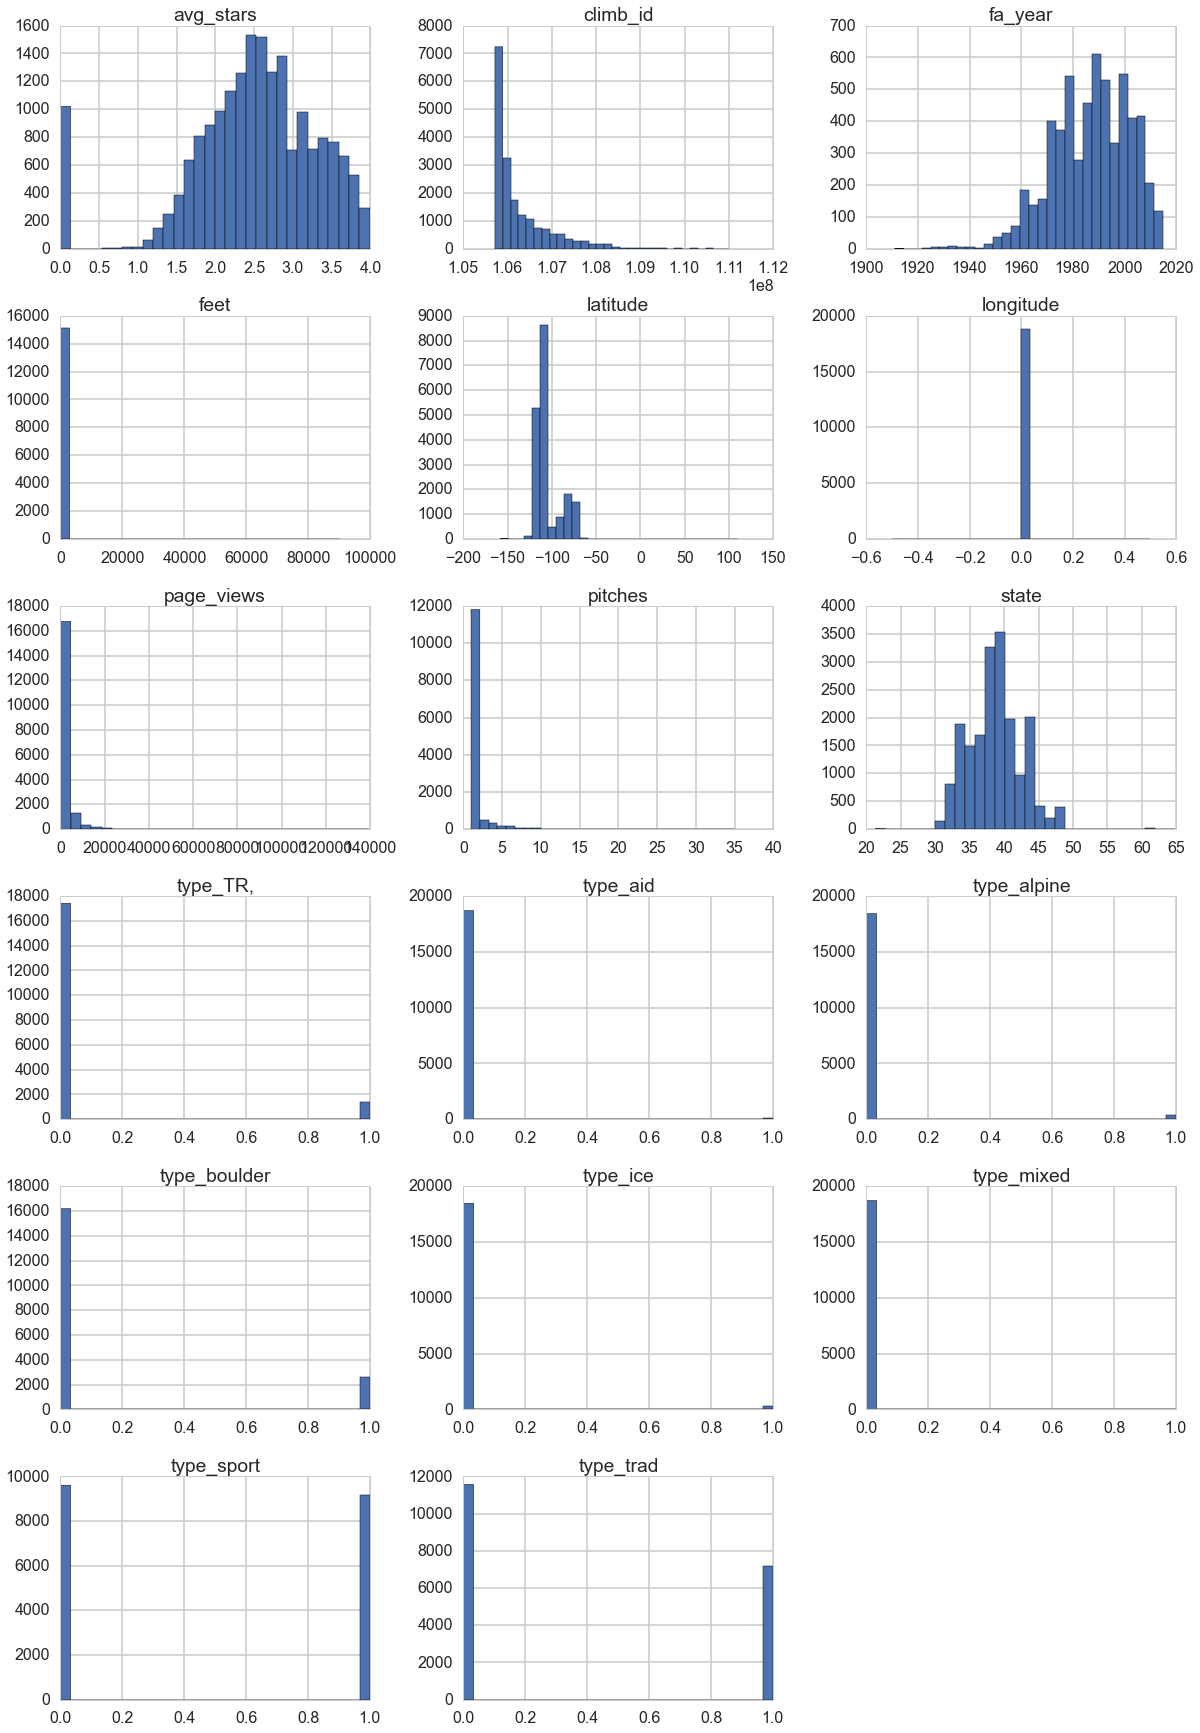

In [208]:
pd.DataFrame.hist(climbsdf, figsize=[20,30], bins=30, layout=(6,3));

#### Notes:
- good thing we didn't go with climb_names for unique identifier as they clearly are not unique
- grade regex was messed up, should have 6 unique things, I know what I did wrong, put multi-character sets in [], so it only pulled single character options, see below, oh well...
- our dataset of 19,000 climbs, and likely mountainproject as a whole, covers 41 states
- counts for guide_grades are too high, need to convert default values to np.nan
- there was a mistake in the regex pulling aid grades and as such there are no +,-s in the code for A[0-5]. It is included, however, in the clean aid grades...
- maximum feet is obviously impossible



### Data Cleaning

#### Figure out weird max feet 

In [209]:
climbsdf[['climb_link','feet']].sort_values('feet', ascending=0, na_position='last')[:10]

,climb_link,feet
107688903,http://www.mountainproject.com/v/wisky-bench/1...,90110
105958680,http://www.mountainproject.com/v/melting-into-...,80110
106565238,http://www.mountainproject.com/v/the-grand-tra...,12000
107070687,http://www.mountainproject.com/v/evolution-tra...,12000
106459197,http://www.mountainproject.com/v/liberty-ridge...,10500
105906991,http://www.mountainproject.com/v/kautz-glacier...,9000
107677399,http://www.mountainproject.com/v/tenaya-matthe...,7500
105856699,http://www.mountainproject.com/v/tutu-man/1058...,6085
107128776,http://www.mountainproject.com/v/hotlum-bolam-...,6000
105792945,http://www.mountainproject.com/v/the-north-fac...,5300


Upon inspection of the pages, the top two results are all just erroniuous. We correct them manually below.

In [210]:
climbsdf.replace([90110,80110],np.nan, inplace=1)

#### Figure out, drop 'grades' column

In [211]:
# why only two unique entries for grades?
climbsdf.grade.unique()

array([nan, 'I', 'V'], dtype=object)

In [212]:
# drop grades column
climbsdf.drop("grade", axis=1, inplace=1)

#### Difficulty Grades Conversion

In [213]:
climb_grades_to_num_dict = {u'guide_aid_grade': aid_grade_convert, u'guide_boulder_grade': boulder_grade_convert, 
                             u'guide_ice_grade': ice_grade_convert, u'guide_mixed_grade': mixed_grade_convert, 
                             u'guide_rock_grade': rock_grade_convert, u'concensus_aid_grade': aid_grade_convert, 
                             u'concensus_boulder_grade': boulder_grade_convert, u'concensus_ice_grade': ice_grade_convert, 
                             u'concensus_mixed_grade': mixed_grade_convert, u'concensus_rock_grade': rock_grade_convert}

for column, converter in climb_grades_to_num_dict.items():
    climbsdf[column + "_number"] = climbsdf[column].apply(converter)

#### fix 'state', 'latitude', 'longitude' columns by joining 

In [214]:
metaclimbsdf = pd.DataFrame.from_csv('../fin_proj_dfs/raw_data/df_routes_lat_long.csv')

In [215]:
print len(metaclimbsdf)
metaclimbsdf.head()

18901


,route_url,state,latitude,longitude
location_url,,,,
http://www.mountainproject.com/v/sea-of-screams/105866044,http://www.mountainproject.com/v/the-hobbit/10...,Oklahoma,34.8913,-99.3014
http://www.mountainproject.com/v/sea-of-screams/105866044,http://www.mountainproject.com/v/accidents-wil...,Oklahoma,34.8913,-99.3014
http://www.mountainproject.com/v/sea-of-screams/105866044,http://www.mountainproject.com/v/super-slide/1...,Oklahoma,34.8913,-99.3014
http://www.mountainproject.com/v/sea-of-screams/105866044,http://www.mountainproject.com/v/whos-got-the-...,Oklahoma,34.8913,-99.3014
http://www.mountainproject.com/v/headwall/105866094,http://www.mountainproject.com/v/last-of-the-g...,Oklahoma,34.8913,-99.3014


In [216]:
climbsdf.drop(["state", "latitude", "longitude"], axis=1, inplace=1)
print len(climbsdf)
climbsdf.head()

18773


,climb_id,climb_name,climb_link,fa_year,feet,page_views,pitches,avg_stars,area_0,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8,area_9,"type_TR,",type_aid,type_alpine,type_boulder,type_ice,type_mixed,type_sport,type_trad,guide_aid_grade,guide_boulder_grade,guide_ice_grade,guide_mixed_grade,guide_rock_grade,concensus_aid_grade,concensus_boulder_grade,concensus_ice_grade,concensus_mixed_grade,concensus_rock_grade,guide_aid_grade_number,guide_rock_grade_number,guide_boulder_grade_number,concensus_rock_grade_number,concensus_boulder_grade_number,concensus_ice_grade_number,guide_ice_grade_number,concensus_mixed_grade_number,guide_mixed_grade_number,concensus_aid_grade_number
105714713,105714713,garden-party,http://www.mountainproject.com/v/garden-party/...,NaN,60,1157,1,2.0769,/destinations/,/v/south-dakota/105708963,/v/falling-rock/105714240,/v/north-canyon-wall/105714312,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,5.8,0,0,0,0,5.8-,NaN,8,NaN,7.7,NaN,NaN,NaN,NaN,NaN,NaN
105714716,105714716,paperboy-centerfold,http://www.mountainproject.com/v/paperboy-cent...,NaN,60,1320,1,2.1333,/destinations/,/v/south-dakota/105708963,/v/falling-rock/105714240,/v/north-canyon-wall/105714312,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,5.8,0,0,0,0,5.8,NaN,8,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
105714719,105714719,blockhead,http://www.mountainproject.com/v/blockhead/105...,NaN,70,1106,1,2.3529,/destinations/,/v/south-dakota/105708963,/v/falling-rock/105714240,/v/north-canyon-wall/105714312,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,1,0,0,0,0,0,5.10,0,0,0,0,5.10,NaN,10,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN
105714722,105714722,central-yellow-wall,http://www.mountainproject.com/v/central-yello...,NaN,20,1377,NaN,3.2857,/destinations/,/v/south-dakota/105708963,/v/custer-state-park/106058091,/v/sylvan-lake-/106887955,/v/outlets/105714243,/v/campground-boulder/105714321,NaN,NaN,NaN,NaN,1,0,0,1,0,0,0,0,0,V3,0,0,0,0,V3,0,0,0,NaN,NaN,3,NaN,3,NaN,NaN,NaN,NaN,NaN
105714728,105714728,waves,http://www.mountainproject.com/v/waves/105714728,NaN,180,9063,2,3.4797,/destinations/,/v/south-dakota/105708963,/v/mount-rushmore-national-memorial/106062228,/v/south-seas/105714249,/v/shipyard-rock/105714333,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,5.8,0,0,0,0,5.8,NaN,8,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN


It is odd that the lengths are different between these two dataframes as we pulled climbs from one. Initially, I assumed it was because of unseccesful scrapes. However, it appears that it is really because of duplicate entries in the first dataframe, as you can see below. The question is whether the location data is different among the duplicates. If it is, we will need a way of selecting which info to use. 

In [217]:
len(metaclimbsdf.route_url.unique())

18773

In [218]:
metaclimbsdf[metaclimbsdf.duplicated('route_url', keep=False)].sort_values(by='route_url')

,route_url,state,latitude,longitude
location_url,,,,
http://www.mountainproject.com/v/lookout-mountain-crag/105745690,http://www.mountainproject.com/v/510-crack-aka...,Colorado,39.74900,-105.24260
http://www.mountainproject.com/v/lookout-mountain-crag/105745690,http://www.mountainproject.com/v/510-crack-aka...,Colorado,39.74900,-105.24260
http://www.mountainproject.com/v/rigid-designator-amphitheatre/105746967,http://www.mountainproject.com/v/7th-testicle/...,Colorado,39.64212,-106.33005
http://www.mountainproject.com/v/rigid-designator-amphitheatre/105746967,http://www.mountainproject.com/v/7th-testicle/...,Colorado,39.64212,-106.33005
http://www.mountainproject.com/v/longs-peakmt-meeker-cirque/105746979,http://www.mountainproject.com/v/alexanders-ch...,Colorado,40.25446,-105.61575
http://www.mountainproject.com/v/longs-peakmt-meeker-cirque/105746979,http://www.mountainproject.com/v/alexanders-ch...,Colorado,40.25446,-105.61575
http://www.mountainproject.com/v/to-the-moon-alice/105955923,http://www.mountainproject.com/v/alice/105955933,Wyoming,41.15620,-105.34750
http://www.mountainproject.com/v/to-the-moon-alice/105955923,http://www.mountainproject.com/v/alice/105955933,Wyoming,41.15620,-105.34750
http://www.mountainproject.com/v/ames-wall/105747000,http://www.mountainproject.com/v/ames-ice-hose...,Colorado,37.93550,-107.80300


It appears that the location data is still the same for all entries and so we drop all but one of each duplicate, choosing which arbitrarily...

In [219]:
metaclimbsdf.drop_duplicates('route_url', inplace=True)

In [220]:
len(metaclimbsdf)

18773

In [221]:
climbsdf = climbsdf.merge(metaclimbsdf, how='inner', left_on='climb_link', right_on='route_url')
climbsdf.drop('route_url',axis=1,inplace=1)

In [222]:
climbsdf.head()

,climb_id,climb_name,climb_link,fa_year,feet,page_views,pitches,avg_stars,area_0,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8,area_9,"type_TR,",type_aid,type_alpine,type_boulder,type_ice,type_mixed,type_sport,type_trad,guide_aid_grade,guide_boulder_grade,guide_ice_grade,guide_mixed_grade,guide_rock_grade,concensus_aid_grade,concensus_boulder_grade,concensus_ice_grade,concensus_mixed_grade,concensus_rock_grade,guide_aid_grade_number,guide_rock_grade_number,guide_boulder_grade_number,concensus_rock_grade_number,concensus_boulder_grade_number,concensus_ice_grade_number,guide_ice_grade_number,concensus_mixed_grade_number,guide_mixed_grade_number,concensus_aid_grade_number,state,latitude,longitude
0,105714713,garden-party,http://www.mountainproject.com/v/garden-party/...,NaN,60,1157,1,2.0769,/destinations/,/v/south-dakota/105708963,/v/falling-rock/105714240,/v/north-canyon-wall/105714312,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,5.8,0,0,0,0,5.8-,NaN,8,NaN,7.7,NaN,NaN,NaN,NaN,NaN,NaN,South Dakota,44.0597,-103.4232
1,105714716,paperboy-centerfold,http://www.mountainproject.com/v/paperboy-cent...,NaN,60,1320,1,2.1333,/destinations/,/v/south-dakota/105708963,/v/falling-rock/105714240,/v/north-canyon-wall/105714312,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,5.8,0,0,0,0,5.8,NaN,8,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,South Dakota,44.0597,-103.4232
2,105714719,blockhead,http://www.mountainproject.com/v/blockhead/105...,NaN,70,1106,1,2.3529,/destinations/,/v/south-dakota/105708963,/v/falling-rock/105714240,/v/north-canyon-wall/105714312,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,1,0,0,0,0,0,5.10,0,0,0,0,5.10,NaN,10,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,South Dakota,44.0597,-103.4232
3,105714722,central-yellow-wall,http://www.mountainproject.com/v/central-yello...,NaN,20,1377,NaN,3.2857,/destinations/,/v/south-dakota/105708963,/v/custer-state-park/106058091,/v/sylvan-lake-/106887955,/v/outlets/105714243,/v/campground-boulder/105714321,NaN,NaN,NaN,NaN,1,0,0,1,0,0,0,0,0,V3,0,0,0,0,V3,0,0,0,NaN,NaN,3,NaN,3,NaN,NaN,NaN,NaN,NaN,South Dakota,43.8477,-103.5668
4,105714728,waves,http://www.mountainproject.com/v/waves/105714728,NaN,180,9063,2,3.4797,/destinations/,/v/south-dakota/105708963,/v/mount-rushmore-national-memorial/106062228,/v/south-seas/105714249,/v/shipyard-rock/105714333,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,5.8,0,0,0,0,5.8,NaN,8,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,South Dakota,43.8864,-103.4670


### Final 'climbsdf' Overview

In [223]:
climbsdf.describe(include=['number'])

,climb_id,fa_year,feet,page_views,pitches,avg_stars,"type_TR,",type_aid,type_alpine,type_boulder,type_ice,type_mixed,type_sport,type_trad,guide_aid_grade_number,guide_rock_grade_number,guide_boulder_grade_number,concensus_rock_grade_number,concensus_boulder_grade_number,concensus_ice_grade_number,guide_ice_grade_number,concensus_mixed_grade_number,guide_mixed_grade_number,concensus_aid_grade_number,latitude,longitude
count,1.877300e+04,5908.000000,15135.000000,18773.000000,13206.000000,18773.000000,18773.000000,18773.000000,18773.000000,18773.000000,18773.000000,18773.000000,18773.000000,18773.000000,77.000000,15963.000000,2513.000000,15962.000000,2504.000000,298.000000,298.000000,55.000000,56.000000,77.000000,18773.000000,18773.000000
mean,1.062857e+08,1987.141503,110.342253,2532.874394,1.515220,2.476971,0.072178,0.004102,0.018377,0.137272,0.016140,0.002983,0.488308,0.383849,1.523377,9.856550,3.088619,9.832045,3.039018,3.335570,3.392617,4.583636,4.673214,1.436364,38.760473,-104.646066
std,7.182032e+05,14.934810,276.555835,4662.915426,1.676495,0.862664,0.258790,0.063914,0.134316,0.344143,0.126018,0.054537,0.499877,0.486335,0.909872,1.781995,2.301309,1.780604,2.261184,0.905321,0.927659,2.138601,2.080602,0.957369,3.802676,15.148212
min,1.057147e+08,1911.000000,4.000000,77.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.300000,0.000000,-0.300000,1.000000,1.000000,0.700000,0.700000,0.000000,21.309100,-158.228700
25%,1.057956e+08,1977.000000,45.000000,796.000000,1.000000,2.076900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.300000,1.000000,8.300000,1.000000,2.700000,2.700000,3.350000,3.600000,1.000000,36.011800,-115.446270
50%,1.059913e+08,1989.000000,65.000000,1369.000000,1.000000,2.545500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,10.000000,3.000000,10.000000,3.000000,3.300000,3.300000,5.000000,5.000000,1.700000,38.788600,-107.715400
75%,1.065176e+08,1999.000000,90.000000,2545.000000,1.000000,3.066700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,11.000000,5.000000,11.000000,4.700000,4.000000,4.000000,6.000000,6.000000,2.000000,40.613440,-103.907650
max,1.110013e+08,2015.000000,12000.000000,139600.000000,35.000000,3.991300,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.300000,15.800000,11.000000,16.500000,13.000000,5.300000,6.000000,11.000000,11.000000,3.000000,64.820900,110.704550


In [224]:
climbsdf.describe(include=['object'])

,climb_name,climb_link,area_0,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8,area_9,guide_aid_grade,guide_boulder_grade,guide_ice_grade,guide_mixed_grade,guide_rock_grade,concensus_aid_grade,concensus_boulder_grade,concensus_ice_grade,concensus_mixed_grade,concensus_rock_grade,state
count,18773,18773,18773,18773,18773,18438,15483,6989,2371,621,87,9,18773,18773,18773,18773,18773,18773,18773,18773,18773,18773,18773
unique,16920,18773,1,41,323,1294,2558,1457,646,199,31,4,14,32,15,20,42,12,35,14,19,42,41
top,unknown,http://www.mountainproject.com/v/tigger-plus/1...,/destinations/,/v/colorado/105708956,/v/wasatch-range/105739213,/v/boulder-canyon/105744222,/v/mount-lemmon-catalina-highway/106822703,/v/1---lower-highway/106822869,/v/central-pinnacles/105931166,/v/motherlode-rock/105837583,/v/motherlode-rock---west-face/105852307,/v/south-astro-dome---northeast-face/106637669,0,0,0,0,0,0,0,0,0,0,Colorado
freq,24,1,18773,3912,1077,543,430,132,74,17,7,5,18696,16260,18475,18717,2810,18696,16269,18475,18718,2811,3912


In [269]:
climb_basic_info = ['fa_year','avg_stars']

climb_basic_info_normalized = ['feet','page_views','pitches']

climb_difficulties = [u'guide_rock_grade_number', u'concensus_rock_grade_number', 
                      u'guide_boulder_grade_number', u'concensus_boulder_grade_number',
                      u'guide_ice_grade_number', u'concensus_ice_grade_number',
                      u'guide_aid_grade_number', u'concensus_aid_grade_number',
                      u'guide_mixed_grade_number', u'concensus_mixed_grade_number']
    


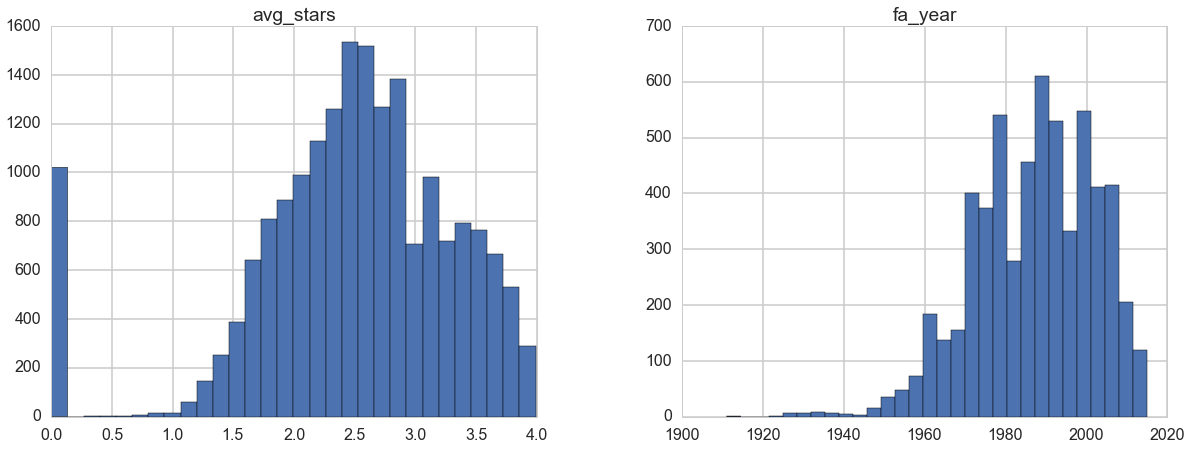

In [243]:
pd.DataFrame.hist(climbsdf[climb_basic_info], figsize=[20,7], bins=30, layout=(1,2));

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000247CA588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000020339828>]], dtype=object)

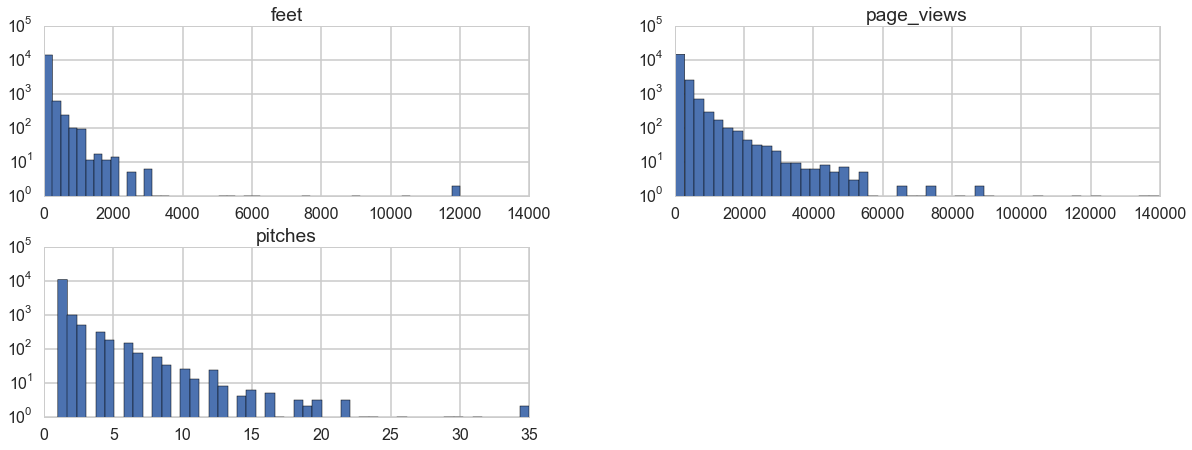

In [238]:
pd.DataFrame.hist(climbsdf[climb_basic_info_normalized], figsize=[20,7], bins=50, layout=(2,2), log=True)

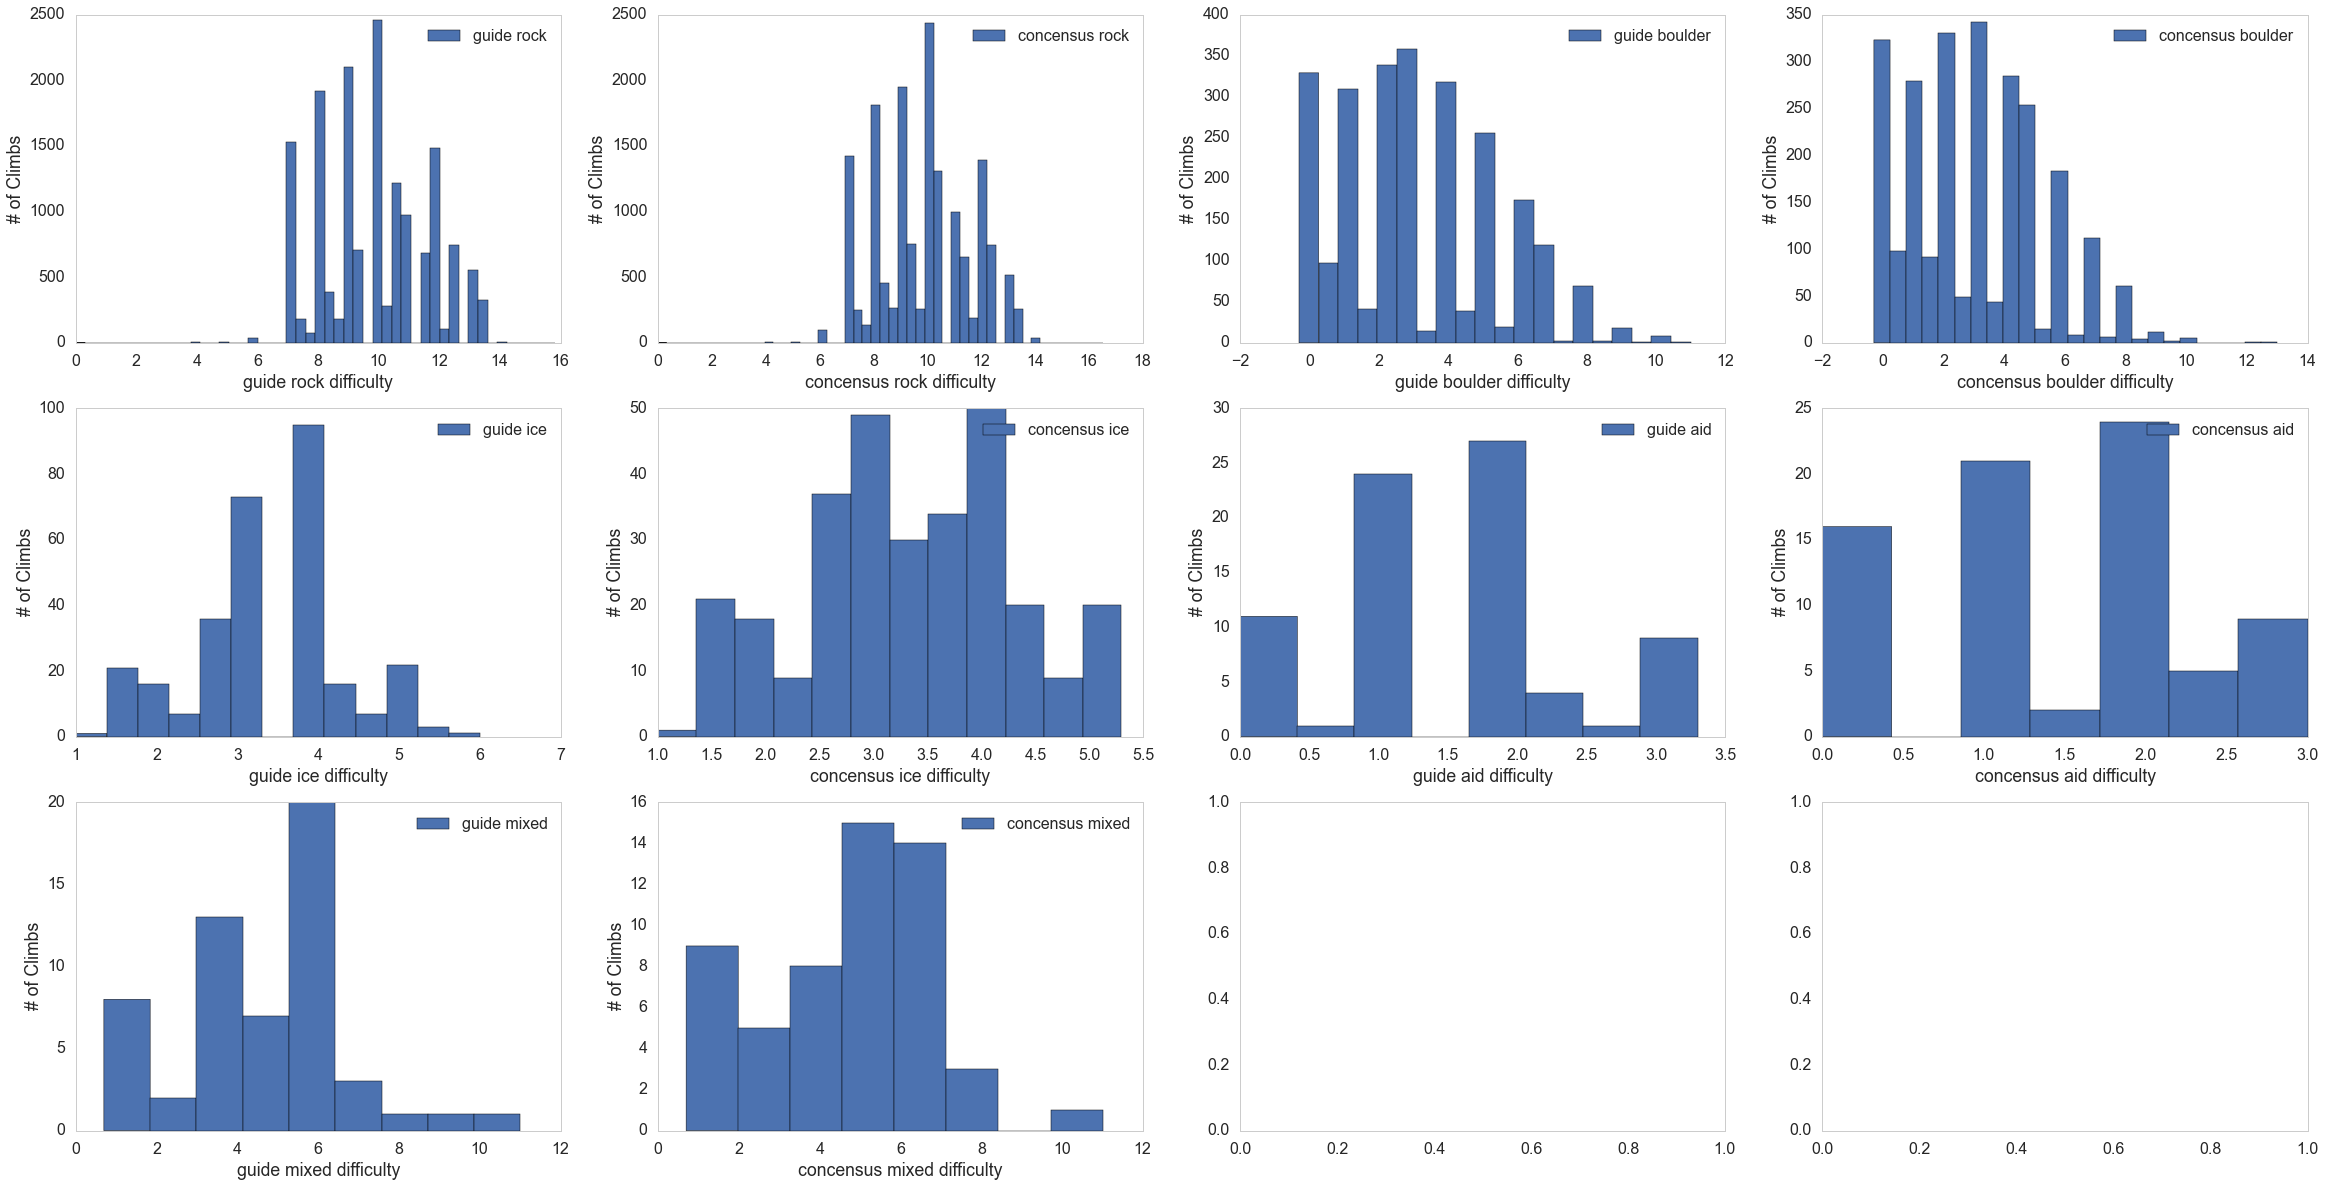

In [275]:
fig1, axes = plt.subplots(nrows=3, ncols=4, figsize=(40, 20))

# make a plot for each
for ax, ccol in zip(axes.ravel(), climb_difficulties):
    
    # get correct labels
    type_climb = ccol.split('_')[1]
    guide_cons = ccol.split('_')[0]
    x_label = guide_cons + ' ' + type_climb + ' difficulty'
    label_ = guide_cons + ' ' + type_climb
        
    sns.distplot(climbsdf[ccol][~np.isnan(climbsdf[ccol])], hist_kws={"alpha": 1}, kde=False, ax=ax, label=label_)
    
    ax.set_ylabel('# of Climbs')
    ax.set_xlabel(x_label)
    ax.legend()
    sns.set_style({'axes.grid':False});


### Export Dataframe

In [277]:
climbsdf.to_csv('../fin_proj_dfs/cleaned_data/cleaned-climbs.csv')

# ClimbUserDF Cleaning and Initial EDA

In [346]:
# you will need to change this to the path to the csv on your machine (too big for github)
ucdf = pd.DataFrame.from_csv('../fin_proj_dfs/raw_data/climb_users.csv')

### 'ucdf' First Look

In [347]:
ucdf.describe(include=['number'])

,climb_id,user_id,star_rating,ticked
count,9.749310e+05,9.749310e+05,642973.000000,770475
mean,1.060692e+08,9.863461e+07,2.781658,1
std,5.469925e+05,2.905350e+07,0.898651,0
min,1.057147e+08,1.000400e+04,0.000000,1
25%,1.057504e+08,1.060775e+08,2.000000,1
50%,1.058613e+08,1.068052e+08,3.000000,1
75%,1.061251e+08,1.077331e+08,3.000000,1
max,1.110013e+08,1.113856e+08,4.000000,1


In [348]:
ucdf.describe(include=['object'])

,tick_date,sugg_aid_grade,sugg_boulder_grade,sugg_ice_grade,sugg_mixed_grade,sugg_rock_grade
count,770475,227805,227805,227805,227805,227805
unique,8870,19,48,17,28,63
top,"time.struct_time(tm_year=2014, tm_mon=10, tm_m...",0,0,0,0,5.9
freq,1044,227072,205385,181918,152895,24684


In [349]:
ucdf.head()

,climb_id,user_id,star_rating,tick_date,ticked,sugg_aid_grade,sugg_boulder_grade,sugg_ice_grade,sugg_mixed_grade,sugg_rock_grade
105714713_10246,105714713,10246,2,NaN,NaN,0,0,0,0,5.8
105714713_105790589,105714713,105790589,2,NaN,NaN,0,0,0,0,5.8
105714713_105829183,105714713,105829183,2,"time.struct_time(tm_year=2007, tm_mon=4, tm_md...",1,NaN,NaN,NaN,NaN,NaN
105714713_105883077,105714713,105883077,NaN,"time.struct_time(tm_year=2006, tm_mon=11, tm_m...",1,NaN,NaN,NaN,NaN,NaN
105714713_105912206,105714713,105912206,NaN,"time.struct_time(tm_year=2013, tm_mon=9, tm_md...",1,NaN,NaN,NaN,NaN,NaN


#### Notes:
- the only bug here seems to be that if any of the suggested grades were found, then all the other suggested grades were marked as 0, so those 0s needs to be replaced by NaNs
- don't see anything else for now...

### Data Cleaning

#### replace zeros with np.nan

In [350]:
columns_with_zeros = ["sugg_aid_grade","sugg_boulder_grade","sugg_ice_grade","sugg_mixed_grade","sugg_rock_grade"]
ucdf[columns_with_zeros] = ucdf[columns_with_zeros].replace([0, '0'],np.nan)

#### convert suggested difficulty ratings to numbers

In [351]:
uc_grades_to_num_dict = {"sugg_aid_grade": aid_grade_convert,"sugg_boulder_grade": boulder_grade_convert,
                            "sugg_ice_grade": ice_grade_convert,"sugg_mixed_grade": mixed_grade_convert,
                            "sugg_rock_grade": rock_grade_convert}

for column, converter in uc_grades_to_num_dict.items():
    ucdf[column + "_number"] = ucdf[column].apply(converter)

#### Convert Tick Dates to Datetime

There MUST have been a better way to do this...

In [352]:
ucdf.tick_date[3]

'time.struct_time(tm_year=2006, tm_mon=11, tm_mday=18, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=5, tm_yday=322, tm_isdst=-1)'

In [373]:
ucdf["tick_date"] = ucdf["tick_date"].str.replace("tm_year=","")
ucdf["tick_date"] = ucdf["tick_date"].str.replace("tm_mon=","")
ucdf["tick_date"] = ucdf["tick_date"].str.replace("tm_mday=","")

In [374]:
ucdf["tick_date"].unique()


array([nan,
       'time.struct_time(2007, 4, 22, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=6, tm_yday=112, tm_isdst=-1)',
       'time.struct_time(2006, 11, 18, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=5, tm_yday=322, tm_isdst=-1)',
       ...,
       'time.struct_time(1985, 8, 17, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=5, tm_yday=229, tm_isdst=-1)',
       'time.struct_time(2018, 8, 6, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=0, tm_yday=218, tm_isdst=-1)',
       'time.struct_time(1981, 5, 1, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=4, tm_yday=121, tm_isdst=-1)'], dtype=object)

In [379]:
ucdf['tick_date'] = ucdf['tick_date'].str.extract(r'time.struct_time\((\d\d\d\d, \d\d?, \d\d?)')

In [401]:
def parse_dates(x):
    if isinstance(x, str): 
        return datetime.strptime(x, '%Y, %m, %d')
    else:
        return np.nan
    
trial = ucdf['tick_date'].apply(lambda x: parse_dates(x))

### Final 'ucdf' Overview

In [284]:
ucdf.describe(include=['number'])

,climb_id,user_id,star_rating,ticked,sugg_ice_grade_number,sugg_boulder_grade_number,sugg_aid_grade_number,sugg_mixed_grade_number,sugg_rock_grade_number
count,9.749310e+05,9.749310e+05,642973.000000,770475,2032.000000,22420.000000,733.000000,440.000000,205783.000000
mean,1.060692e+08,9.863461e+07,2.781658,1,3.396555,3.198671,1.278718,4.235227,9.688254
std,5.469925e+05,2.905350e+07,0.898651,0,0.922260,2.210503,0.969246,1.945911,1.802669
min,1.057147e+08,1.000400e+04,0.000000,1,1.000000,-0.300000,-0.300000,0.700000,0.000000
25%,1.057504e+08,1.060775e+08,2.000000,1,2.700000,1.300000,0.000000,3.000000,8.300000
50%,1.058613e+08,1.068052e+08,3.000000,1,3.300000,3.000000,1.000000,4.500000,10.000000
75%,1.061251e+08,1.077331e+08,3.000000,1,4.000000,5.000000,2.000000,6.000000,11.000000
max,1.110013e+08,1.113856e+08,4.000000,1,6.000000,16.000000,5.000000,11.000000,22.000000


In [285]:
ucdf.describe(include=['object'])

,tick_date,sugg_aid_grade,sugg_boulder_grade,sugg_ice_grade,sugg_mixed_grade,sugg_rock_grade
count,770475,733,22420,2032,440,205783
unique,8870,18,47,15,26,62
top,"time.struct_time(tm_year=2014, tm_mon=10, tm_m...",C2,V3,WI4,M6,5.9
freq,1044,192,2799,366,80,24684


In [286]:
ucdf.head()

,climb_id,user_id,star_rating,tick_date,ticked,sugg_aid_grade,sugg_boulder_grade,sugg_ice_grade,sugg_mixed_grade,sugg_rock_grade,sugg_ice_grade_number,sugg_boulder_grade_number,sugg_aid_grade_number,sugg_mixed_grade_number,sugg_rock_grade_number
105714713_10246,105714713,10246,2,NaN,NaN,NaN,NaN,NaN,NaN,5.8,NaN,NaN,NaN,NaN,8
105714713_105790589,105714713,105790589,2,NaN,NaN,NaN,NaN,NaN,NaN,5.8,NaN,NaN,NaN,NaN,8
105714713_105829183,105714713,105829183,2,"time.struct_time(tm_year=2007, tm_mon=4, tm_md...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105714713_105883077,105714713,105883077,NaN,"time.struct_time(tm_year=2006, tm_mon=11, tm_m...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105714713_105912206,105714713,105912206,NaN,"time.struct_time(tm_year=2013, tm_mon=9, tm_md...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [287]:
uc_hist_headers  =  ['star_rating',
                     'tick_date',
                     'sugg_ice_grade_number',
                     'sugg_boulder_grade_number',
                     'sugg_aid_grade_number',
                     'sugg_mixed_grade_number',
                     'sugg_rock_grade_number']

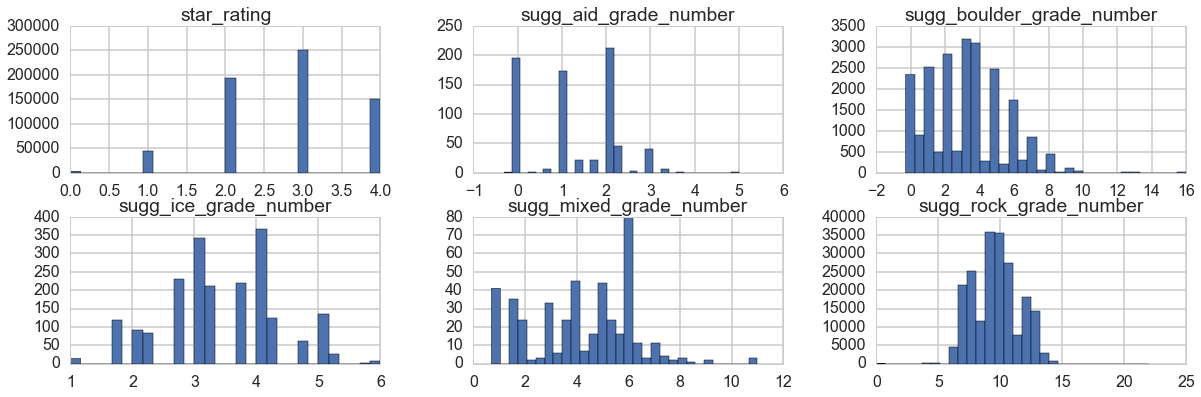

In [288]:
pd.DataFrame.hist(ucdf[uc_hist_headers], figsize=[20,30], bins=30, layout=(9,3));

### Exporting 'cleaned-ucdf.csv'

In [404]:
# only run below if you actually made changes above
ucdf.to_csv('../fin_proj_dfs//cleaned_data/cleaned-ucdf.csv')

# Joining the Data Frames

In [405]:
print ucdf.shape
print climbsdf.shape
print usersdf.shape

(974931, 15)
(18773, 49)
(11323, 44)


In [406]:
alldf = ucdf.merge(usersdf, how='inner', left_on='user_id', right_on='user_id')
alldf = alldf.merge(climbsdf, how='inner', left_on='climb_id', right_on='climb_id')

In [407]:
alldf.shape

(792560, 106)

The length of this new combined df is much less than the original 990,000 dataframe. A possible expalanation, is that it is smaller because it excludes all user_climb pairings that have a user with total ratings < 5 (this was our criteria for scraping user pages). We explore this below.

In [408]:
print "Users in usersdf: ", len(usersdf.user_id.unique())
print "Users in ucdf: ", len(ucdf.user_id.unique())

print "Observations in ucdf only counting users in usersdf: ", len(ucdf[ucdf.user_id.isin(usersdf.user_id.unique())])
print "Observations in alldf: ", len(alldf)

Users in usersdf:  11323
Users in ucdf:  27534
Observations in ucdf only counting users in usersdf:  792560
Observations in alldf:  792560


Our thoughts are confirmed!

### Exporting Joined DF

In [409]:
alldf.member_date.unique()

array(['2000-12-31T19:00:00.000000000-0500',
       '2006-01-25T19:00:00.000000000-0500',
       '2006-05-30T20:00:00.000000000-0400', ...,
       '2005-03-17T20:00:00.000000000-0400',
       '2008-02-07T19:00:00.000000000-0500',
       '2015-11-29T19:00:00.000000000-0500'], dtype='datetime64[ns]')

In [410]:
# only run changes to below if you actually made changes above
alldf.to_csv('../fin_proj_dfs/cleaned_data/cleaned-all-joined-df.csv')

In [411]:
alldf.head()

,climb_id,user_id,star_rating,tick_date,ticked,sugg_aid_grade,sugg_boulder_grade,sugg_ice_grade,sugg_mixed_grade,sugg_rock_grade,sugg_ice_grade_number,sugg_boulder_grade_number,sugg_aid_grade_number,sugg_mixed_grade_number,sugg_rock_grade_number,climbs_trad,gender,age,climbs_aid,user_country,user_state,user_city,user_zip_code,climbs_ice,climbs_boulder,user_link,climbs_mixed,climbs_sport,member_date,user_name,lead_diff_sport,boulder_diff,follow_diff_sport,lead_diff_ice,lead_diff_trad,follow_diff_ice,follow_diff_trad,follow_diff_mixed,lead_diff_mixed,follow_diff_aid,lead_diff_aid,lead_diff_sport_number,follow_diff_aid_number,lead_diff_ice_number,follow_diff_sport_number,follow_diff_mixed_number,lead_diff_aid_number,lead_diff_mixed_number,lead_diff_trad_number,boulder_diff_number,...,user_zip_geo,user_country_geo,climb_name,climb_link,fa_year,feet,page_views,pitches,avg_stars,area_0,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8,area_9,"type_TR,",type_aid,type_alpine,type_boulder,type_ice,type_mixed,type_sport,type_trad,guide_aid_grade,guide_boulder_grade,guide_ice_grade,guide_mixed_grade,guide_rock_grade,concensus_aid_grade,concensus_boulder_grade,concensus_ice_grade,concensus_mixed_grade,concensus_rock_grade,guide_aid_grade_number,guide_rock_grade_number,guide_boulder_grade_number,concensus_rock_grade_number,concensus_boulder_grade_number,concensus_ice_grade_number,guide_ice_grade_number,concensus_mixed_grade_number,guide_mixed_grade_number,concensus_aid_grade_number,state,latitude_y,longitude_y
0,105714713,10246,2,NaN,NaN,NaN,NaN,NaN,NaN,5.8,NaN,NaN,NaN,NaN,8,1,0,38,1,USA,UT,Salt Lake City,NaN,1,1,https://www.mountainproject.com/u/andrew-gram/...,0,1,2001-01-01,andrew-gram,5.9,V1,5.10a,WI3,5.9,WI5,5.10b,NaN,NaN,C1,C3,9,1,3,10.0,NaN,3,NaN,9,1,...,NaN,USA,garden-party,http://www.mountainproject.com/v/garden-party/...,NaN,60,1157,1,2.0769,/destinations/,/v/south-dakota/105708963,/v/falling-rock/105714240,/v/north-canyon-wall/105714312,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,5.8,0,0,0,0,5.8-,NaN,8,NaN,7.7,NaN,NaN,NaN,NaN,NaN,NaN,South Dakota,44.0597,-103.4232
1,105714713,105790589,2,NaN,NaN,NaN,NaN,NaN,NaN,5.8,NaN,NaN,NaN,NaN,8,1,0,37,0,USA,SD,Rapid City,NaN,0,1,https://www.mountainproject.com/u/brian-k//105...,0,1,2006-01-26,brian-k,NaN,V0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,NaN,USA,garden-party,http://www.mountainproject.com/v/garden-party/...,NaN,60,1157,1,2.0769,/destinations/,/v/south-dakota/105708963,/v/falling-rock/105714240,/v/north-canyon-wall/105714312,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,5.8,0,0,0,0,5.8-,NaN,8,NaN,7.7,NaN,NaN,NaN,NaN,NaN,NaN,South Dakota,44.0597,-103.4232
2,105714713,105829183,2,2007-04-22 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,37,0,USA,SD,Rapid City,NaN,0,0,https://www.mountainproject.com/u/joelhagan//1...,0,1,2006-05-31,joelhagan,5.9,NaN,5.10b,NaN,5.9,NaN,5.10a,NaN,NaN,NaN,NaN,9,NaN,NaN,10.5,NaN,NaN,NaN,9,NaN,...,NaN,USA,garden-party,http://www.mountainproject.com/v/garden-party/...,NaN,60,1157,1,2.0769,/destinations/,/v/south-dakota/105708963,/v/falling-rock/105714240,/v/north-canyon-wall/105714312,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,5.8,0,0,0,0,5.8-,NaN,8,NaN,7.7,NaN,NaN,NaN,NaN,NaN,NaN,South Dakota,44.0597,-103.4232
3,105714713,105883077,NaN,2006-11-18 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,30,0,USA,VA,Fairfax,NaN,0,0,https://www.mountainproject.com/u/paxton-alsga...,0,1,2006-11-05,paxton-alsgaard,5.9,NaN,5.10a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,...,NaN,USA,garden-party,http://www.mountainproject.com/v/garden-party/...,NaN,60,1157,1,2.0769,/destinations/,/v/south-dakota/105708963,/v/falling-rock/105714240,/v/north-canyon-wall/105714312,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,5.8,0,0,0,0,5.8-,NaN,8,NaN,7.7,NaN,NaN,NaN,NaN,NaN,NaN,South Dakota,44.0597,-103.4232
4,105714713,105912206,NaN,2013-09-15 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,5

# Random Errors

### Missing Climbs?
Below, I looked for the most difficult climbs in Massachusetts. However, a couple that were missing have more than 10 star_ratings so I have no idea why they were excluded from our search. Something was off with the climb gathering code!

In [412]:
climbsdf[climbsdf.guide_rock_grade_number > 14]

,climb_id,climb_name,climb_link,fa_year,feet,page_views,pitches,avg_stars,area_0,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8,area_9,"type_TR,",type_aid,type_alpine,type_boulder,type_ice,type_mixed,type_sport,type_trad,guide_aid_grade,guide_boulder_grade,guide_ice_grade,guide_mixed_grade,guide_rock_grade,concensus_aid_grade,concensus_boulder_grade,concensus_ice_grade,concensus_mixed_grade,concensus_rock_grade,guide_aid_grade_number,guide_rock_grade_number,guide_boulder_grade_number,concensus_rock_grade_number,concensus_boulder_grade_number,concensus_ice_grade_number,guide_ice_grade_number,concensus_mixed_grade_number,guide_mixed_grade_number,concensus_aid_grade_number,state,latitude,longitude
3077,105752932,triple-exposure,http://www.mountainproject.com/v/triple-exposu...,NaN,NaN,4486,4,2.0909,/destinations/,/v/colorado/105708956,/v/colorado-springs/105800307,/v/garden-of-the-gods/105744301,/v/north-gateway-rock/105745271,/v/north-face--north-end/107362108,NaN,NaN,NaN,NaN,0,1,0,0,0,0,1,1,C1,0,0,0,5.12c/d,C2-,0,0,0,5.4,1,15.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,1.7,Colorado,38.88103,-104.88143
11425,106147074,reversal-roof,http://www.mountainproject.com/v/reversal-roof...,NaN,25,2335,1,1.4000,/destinations/,/v/colorado/105708956,/v/boulder/105801420,/v/boulder-canyon/105744222,/v/animal-world/105744917,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,1,0,0,V7,0,0,5.13-,0,V7,0,0,5.13-,NaN,15.8,7,15.8,7,NaN,NaN,NaN,NaN,NaN,Colorado,39.99780,-105.41490
13338,106400153,the-crackhouse,http://www.mountainproject.com/v/the-crackhous...,NaN,85,5251,NaN,3.9167,/destinations/,/v/utah/105708957,/v/moab-area/105716711,/v/crackhouse/105947902,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1,0,V8,0,0,5.13-,0,V8,0,0,5.13-,NaN,15.8,8,15.8,8,NaN,NaN,NaN,NaN,NaN,Utah,38.58924,-109.69932
